## Time_series_anaysis


In [9]:
import yfinance as yf

# Download stock data for a specific ticker (Apple in this case)
ticker = 'AAPL'
stock_data = yf.download(ticker, start="2010-01-01", end="2025-01-01")

# Show the first few rows of the data
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440332  6.455078  6.391279  6.422878  493729600
2010-01-05  6.451466  6.487879  6.417460  6.458087  601904800
2010-01-06  6.348848  6.477047  6.342227  6.451467  552160000
2010-01-07  6.337108  6.379842  6.291065  6.372318  477131200
2010-01-08  6.379241  6.379844  6.291369  6.328684  447610800


#### visualize the data 

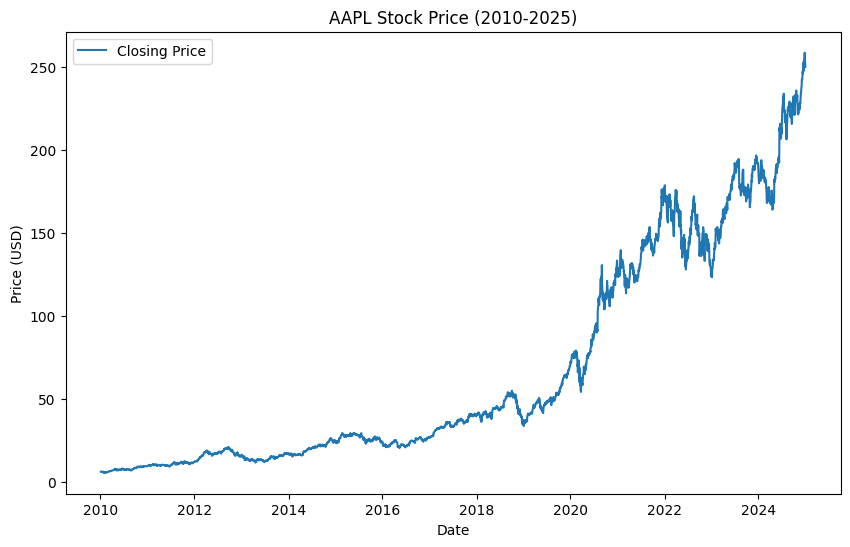

In [10]:
import matplotlib.pyplot as plt

# Visualize the Closing Price
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Closing Price')
plt.title(f'{ticker} Stock Price (2010-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


#### Check for Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller

# ADF Test function to check stationarity
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")
        
# Apply ADF test on the Closing Price
adf_test(stock_data['Close'])


ADF Statistic: 1.7035852741176787
p-value: 0.9981373323168812
Series is not stationary


#### Make Data Stationary

In [ ]:
# Differencing to make the data stationary
stock_data['Close_diff'] = stock_data['Close'].diff().dropna()

# Apply ADF test again on the differenced data
adf_test(stock_data['Close_diff'].dropna())
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B')  # 'B' indicates business days



ADF Statistic: -14.230225721894321
p-value: 1.601295724191558e-26
Series is stationary


#### Plot ACF and PACF to Find Optimal p and q

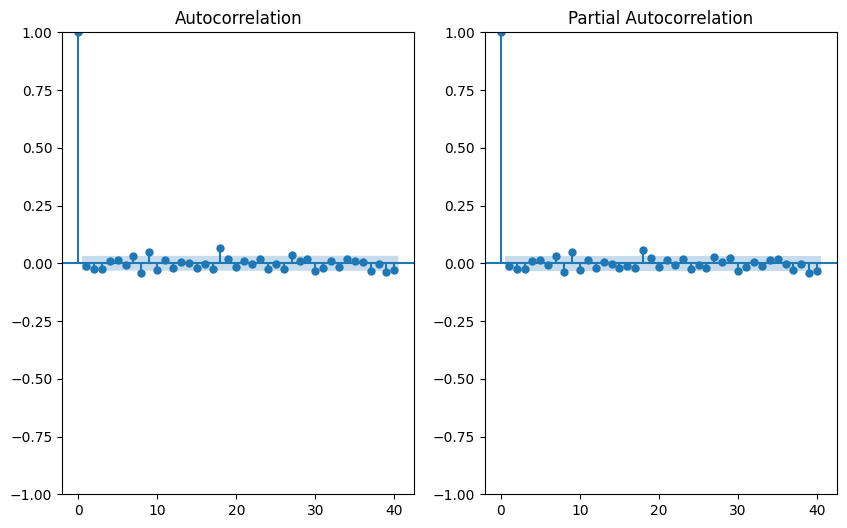

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced data
plt.figure(figsize=(10, 6))
plt.subplot(121)
plot_acf(stock_data['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.subplot(122)
plot_pacf(stock_data['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.show()


#### Make Predictions


In [18]:
from statsmodels.tsa.arima.model import ARIMA
# import pandas frame
import pandas as pd
# Fit ARIMA model with p=1, d=1, q=1
model = ARIMA(stock_data['Close'], order=(1, 1, 1))

# Fit the model
model_fit = model.fit()
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B')  # 'B' is for business day frequency

# Print model summary to see coefficients
print(model_fit.summary())


/Users/akshaykharat/euron/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/akshaykharat/euron/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 3912
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7083.661
Date:                Mon, 10 Mar 2025   AIC                          14173.321
Time:                        14:26:21   BIC                          14192.136
Sample:                    01-04-2010   HQIC                         14179.998
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4560      0.224      2.034      0.042       0.017       0.895
ma.L1         -0.4837      0.222     -2.180      0.029      -0.919      -0.049
sigma2         2.4419      0.023    107.660      0.0

#### Make Predictions

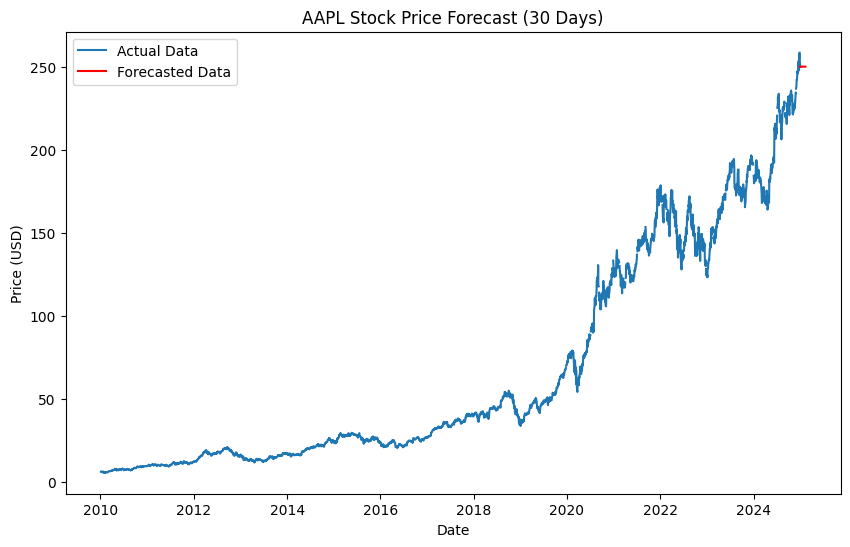

In [19]:

# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

# Create a date range for the forecasted period
forecast_index = pd.date_range(stock_data.index[-1], periods=30, freq='B')

# Plot the actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Actual Data')
plt.plot(forecast_index, forecast, label='Forecasted Data', color='red')
plt.title(f'{ticker} Stock Price Forecast (30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B')  # 'B' indicates business days



#### Evaluate the Model

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data: training data (all except the last 30 days) and test data (last 30 days)
train_data = stock_data['Close'][:-30]
test_data = stock_data['Close'][-30:]

# Make predictions for the test set (forecast next 30 days)
predicted = model_fit.forecast(steps=30)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_data, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 11.50613147598112


/Users/akshaykharat/euron/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
